In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prices = pd.read_excel('Price.xlsx')
M_TRESO =  pd.read_excel('interest.xlsx')

prices['Date'] = pd.to_datetime(prices['Date'], format = '%Y-%m-%d')
M_TRESO['Date'] = pd.to_datetime(M_TRESO['Date'], format = '%m/%Y')
M_TRESO['France']  = M_TRESO['France'].replace('-',np.nan)
M_TRESO = M_TRESO.sort_values(by = 'Date')
M_TRESO['France'] = M_TRESO['France'].ffill()

#Interpolate the yearly 3M gov yield to daily
M_TRESO.set_index('Date', inplace=True)
daily_M_TRESO = M_TRESO.resample('D').mean()
daily_M_TRESO.interpolate(method='linear', inplace=True)

prices = prices.sort_values(by = 'Date')
prices_int = prices.merge( daily_M_TRESO, on = 'Date', how='left' )

In [3]:
main_df = prices_int[['Date','Price','France']].dropna().rename(columns={"France":'STR'})
main_df['STR'] = main_df['STR'].div(100)

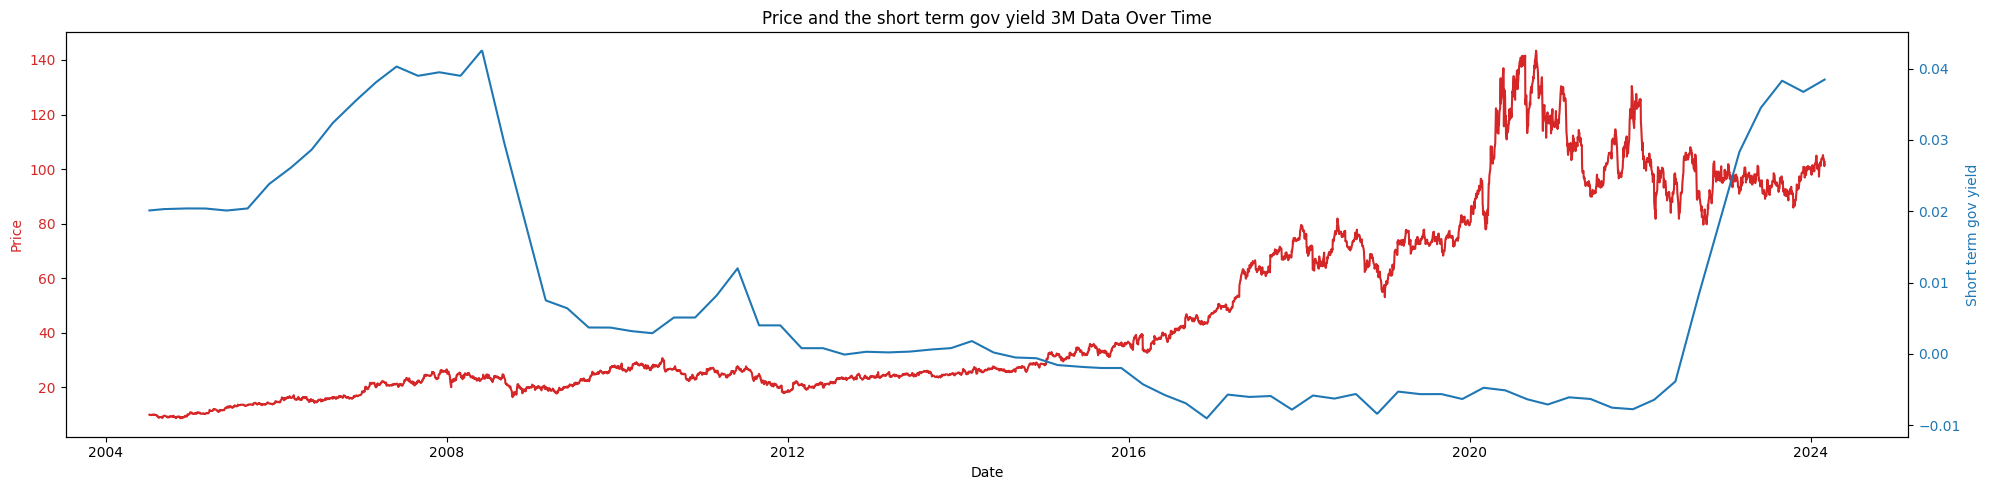

In [4]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(main_df.Date, main_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Short term gov yield', color=color)  # we already handled the x-label with ax1
ax2.plot(main_df.Date, main_df['STR'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and the short term gov yield 3M Data Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


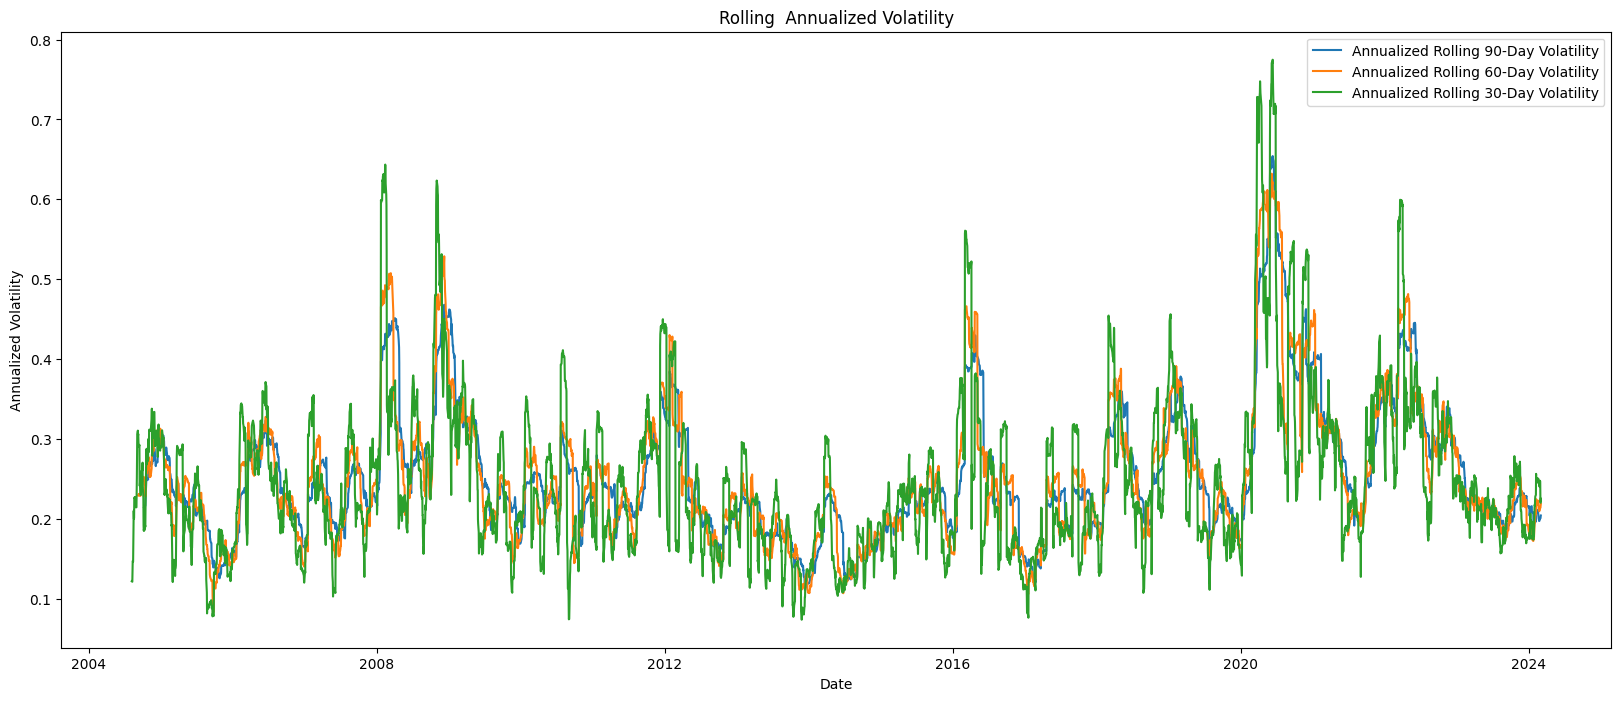

In [5]:
main_df['Daily Returns'] = main_df['Price'].pct_change()
# Calculate rolling 30-day standard deviation of daily returns and annualize it
main_df['Rolling_Volatility3M'] = main_df['Daily Returns'].rolling(window=66).std() * np.sqrt(252)
main_df['Rolling_Volatility2M'] = main_df['Daily Returns'].rolling(window=44).std() * np.sqrt(252)
main_df['Rolling_Volatility1M'] = main_df['Daily Returns'].rolling(window=22).std() * np.sqrt(252)

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(main_df.Date, main_df['Rolling_Volatility3M'], label='Annualized Rolling 90-Day Volatility')
plt.plot(main_df.Date, main_df['Rolling_Volatility2M'], label='Annualized Rolling 60-Day Volatility')
plt.plot(main_df.Date, main_df['Rolling_Volatility1M'], label='Annualized Rolling 30-Day Volatility')

plt.title('Rolling  Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()


In [6]:
main_df

,Date,Price,STR,Daily Returns,Rolling_Volatility3M,Rolling_Volatility2M,Rolling_Volatility1M
4825,2004-07-07,9.999999,0.020117,NaN,NaN,NaN,NaN
4826,2004-07-08,9.950000,0.020121,-0.005000,NaN,NaN,NaN
4827,2004-07-09,9.900000,0.020124,-0.005025,NaN,NaN,NaN
4828,2004-07-12,9.900000,0.020134,0.000000,NaN,NaN,NaN
4829,2004-07-13,9.833333,0.020137,-0.006734,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9857,2024-02-26,103.250000,0.038394,-0.018069,0.201425,0.214149,0.247846
9858,2024-02-27,103.500000,0.038413,0.002421,0.200569,0.213559,0.246637
9859,2024-02-28,102.350000,0.038432,-0.011111,0.201020,0.214555,0.220411
9860,2024-02-29,101.100000,0.038451,-0.012213,0.202488,0.216566,0.220331


In [7]:
import numpy as np
from scipy.stats import norm

def black_scholes_div(S, K, T, r, sigma, q, option_type='call'):
    """
    Calculate the Black-Scholes option price for a call or put option with dividend yield.

    Parameters:
    S (float): Stock price
    K (float): Strike price
    T (float): Time to expiration in years
    r (float): Risk-free rate (annual)
    sigma (float): Volatility of the stock's returns (annual)
    q (float): Dividend yield (annual)
    option_type (str): 'call' for call option, 'put' for put option

    Returns:
    float: Black-Scholes option price
    """
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        call_price = (S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        return call_price
    else:
        put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1))
        return put_price
import numpy as np
from scipy.stats import norm

def monte_carlo_option_pricing(S, K, T, r, sigma, q, option_type='call', num_simulations=10000):
    """
    Monte Carlo simulation for European option pricing using Geometric Brownian Motion (GBM).

    Parameters:
    S (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of returns
    q (float): Dividend yield
    option_type (str): Type of option ('call' or 'put')
    num_simulations (int): Number of simulations

    Returns:
    float: Estimated option price
    """
    # Time increment
    dt = 1/252  # Daily steps

    # Simulating num_simulations paths
    Z = np.random.normal(0, 1, num_simulations)
    ST = S * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)  # Terminal stock prices

    # Calculate payoffs for call and put options
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)  # Call payoff
    else:
        payoffs = np.maximum(K - ST, 0)  # Put payoff

    # Discount payoffs back to present value and average
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price
from scipy.stats import norm

import numpy as np
from scipy.stats import norm

def calculate_greeks(row, option_type='call'):
    S = row['Price']
    K = 110
    T = row['T']   # Convert days to years if T is in days
    r = row['STR']# Example static risk-free rate, adjust as needed
    sigma = row['Rolling_Volatility3M']  # You can choose which volatility measure to use
    q = row['q']  # Dividend yield

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate Greeks based on option type
    if option_type == 'call':
        delta = np.exp(-q * T) * norm.cdf(d1)
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        delta = -np.exp(-q * T) * norm.cdf(-d1)
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * norm.cdf(d2 if option_type=='call' else -d2)
             + q * S * np.exp(-q * T) * norm.cdf(d1 if option_type=='call' else -d1))
    vega = S * np.sqrt(T) * np.exp(-q * T) * norm.pdf(d1) * 0.01  # per 1% change in volatility
    rho = K * T * np.exp(-r * T) * norm.cdf(d2 if option_type=='call' else -d2) * 0.01  # per 1% change in interest rate

    return pd.Series({'Price': price, 'Delta': delta, 'Gamma': gamma, 'Theta': theta, 'Vega': vega, 'Rho': rho})


import numpy as np
from scipy.stats import norm

import numpy as np
from scipy.stats import norm
import pandas as pd

def calculate_original_greeks(row):
    S = row['Price']
    K = 110
    T = row['T']   # Assuming T is given in days, convert to years
    r = row['STR']  # Static risk-free rate, adjust as necessary
    sigma = row['Rolling_Volatility3M']
    q = row['q']

    # Black-Scholes calculations
    return black_scholes_greeks(S, K, T, r, sigma, q)

def calculate_adjusted_greeks(row):
    S = row['Price']
    K =  110
    T = row['T']
    r = row['STR'] * (1 - (0.019 + np.random.uniform(-0.005, 0.005)))
    sigma = row['Rolling_Volatility3M'] * (1 + (0.034 + np.random.uniform(-0.005, 0.005)))  # 3.4% increase varied by ±0.5%
    q = row['q']

    # Black-Scholes calculations
    return black_scholes_greeks(S, K, T, r, sigma, q)

def black_scholes_greeks(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return {
        'Delta': np.exp(-q * T) * norm.cdf(d1),
        'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
        'Theta': -S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2) + q * S * np.exp(-q * T) * norm.cdf(d1),
        'Vega': S * np.sqrt(T) * np.exp(-q * T) * norm.pdf(d1) * 0.01,  # scaled for 1% change
        'Rho': K * T * np.exp(-r * T) * norm.cdf(d2) * 0.01  # scaled for 1% change
    }





# Price a call using Black and scholes (t-255), t= latest date in the dataset


1.   Strike 110
2.   Maturity 01/03/2025
3.   Volatility
4.   interest rate
5.   Divdend = 0.85 EURO






In [ ]:
#price a call at 01/03/2023 maturity 01/03/2024
#See how the price evolves across time up to maturity


In [8]:
main_df['q'] = 0.85/main_df['Price']
maturity_date = '2024-02-29'
maturity_date = pd.to_datetime(maturity_date)
main_df['DTE'] = (maturity_date - main_df['Date']).dt.days
main_df['DTE'] = main_df['DTE'].apply(lambda x: x if x >= 0 else 0)
main_df['T'] = main_df['DTE'] / 365


NameError: name 'bs_df' is not defined

In [9]:
bs_df = main_df[main_df['Date']>='2023-03-01']
bs_df['BS_CALL'] =  bs_df.apply(black_scholes_div)

TypeError: black_scholes_div() missing 5 required positional arguments: 'K', 'T', 'r', 'sigma', and 'q'

In [11]:
# Constants
VOL_COLUMN = 'Rolling_Volatility3M'  # Example volatility column

# Applying the function to the DataFrame
bs_df['BS_CALL'] = bs_df.apply(lambda row: black_scholes_div(
    S=row['Price'],
    K=110,
    T=row['T'],  # Assuming 'T' is in days and needs to be converted to years
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='call'
), axis=1)


<ipython-input-7-f3d6c99e6def>:21: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-11-f00c03a25a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['BS_CALL'] = bs_df.apply(lambda row: black_scholes_div(


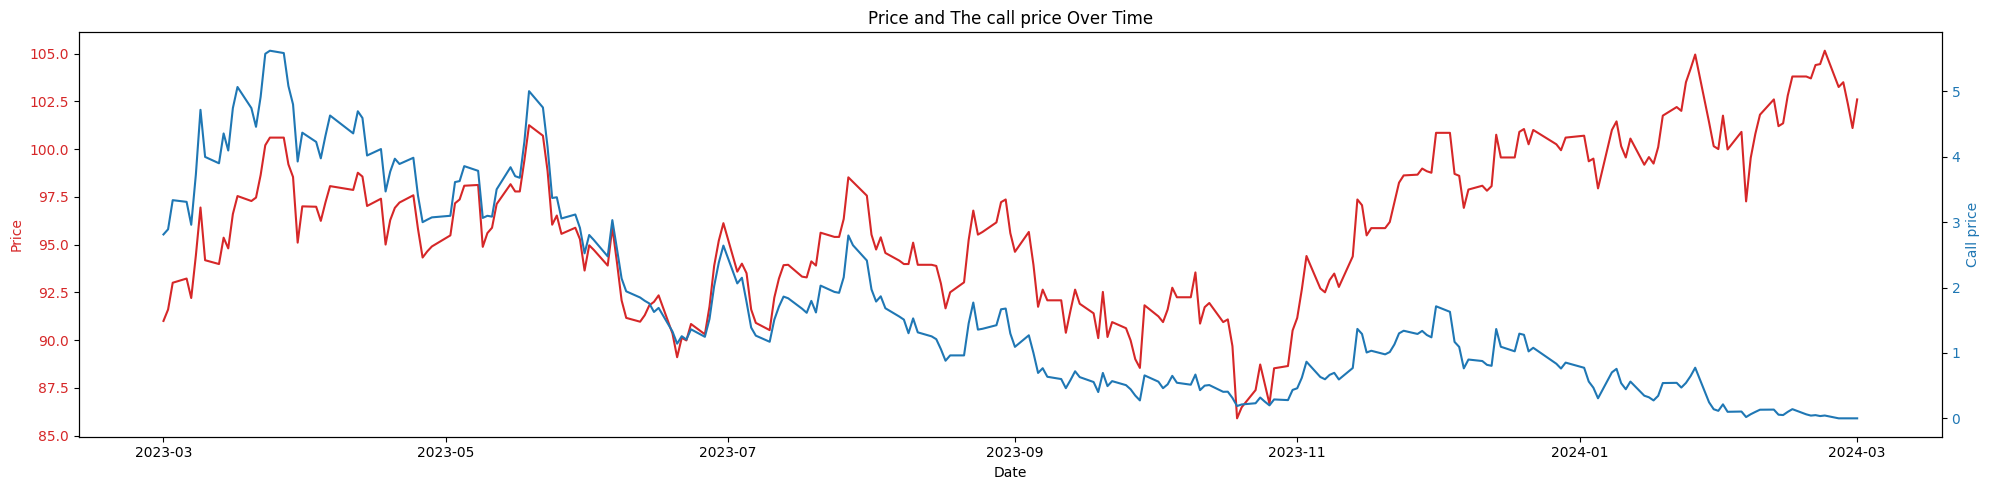

In [12]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(bs_df.Date, bs_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Call price', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_CALL'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and The call price Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Price a put using a

In [13]:
VOL_COLUMN = 'Rolling_Volatility3M'  # Example volatility column

# Applying the function to the DataFrame
bs_df['BS_PUT'] = bs_df.apply(lambda row: black_scholes_div(
    S=row['Price'],
    K=110,
    T=row['T'],  # Assuming 'T' is in days and needs to be converted to years
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='put'
), axis=1)


<ipython-input-7-f3d6c99e6def>:21: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-13-19fe5f84f74e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['BS_PUT'] = bs_df.apply(lambda row: black_scholes_div(


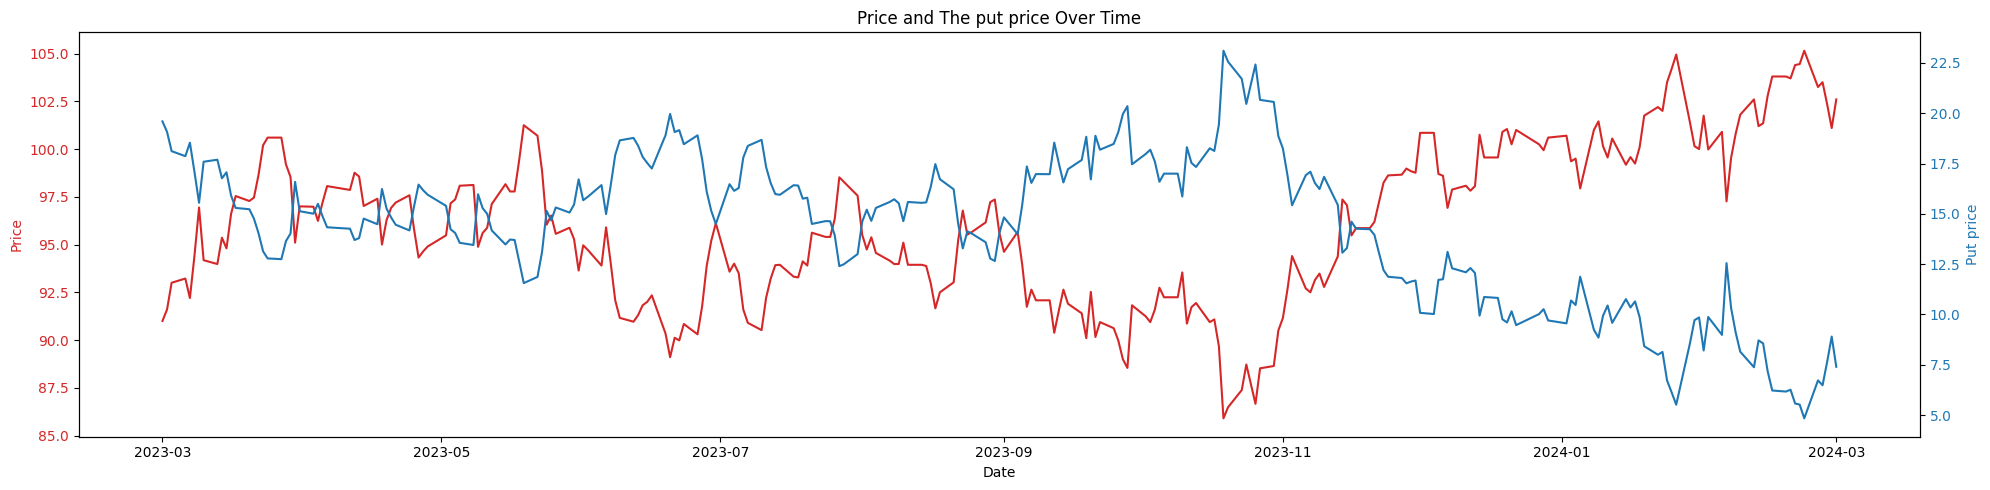

In [14]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(bs_df.Date, bs_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Put price', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_PUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and The put price Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [15]:
# Constants
RISK_FREE_RATE = 0.01  # Example risk-free rate (1%)
VOL_COLUMN = 'Rolling_Volatility3M'  # Choosing appropriate volatility based on your preference
NUM_SIMULATIONS = 7000  # Number of simulations per option

# Calculate call and put prices using Monte Carlo simulation
bs_df['MC_CALL'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
    S=row['Price'],
    K=110,
    T=row['T'] ,  # Convert 'T' from days to years if necessary
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='call',
    num_simulations=NUM_SIMULATIONS
), axis=1)

bs_df['MC_PUT'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
    S=row['Price'],
    K=110,
    T=row['T'] ,  # Convert 'T' from days to years if necessary
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='put',
    num_simulations=NUM_SIMULATIONS
), axis=1)


<ipython-input-15-c0a4c1d4af7f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['MC_CALL'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
<ipython-input-15-c0a4c1d4af7f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['MC_PUT'] = bs_df.apply(lambda row: monte_carlo_option_pricing(


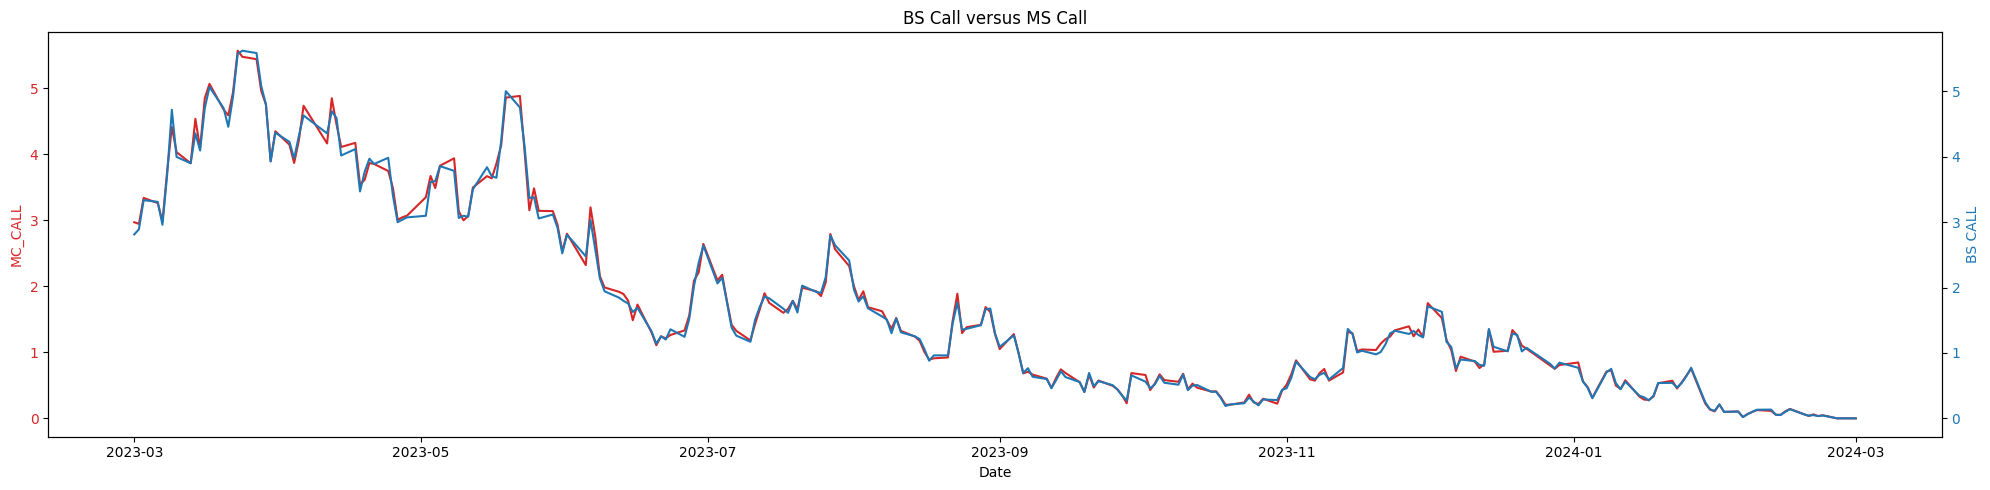

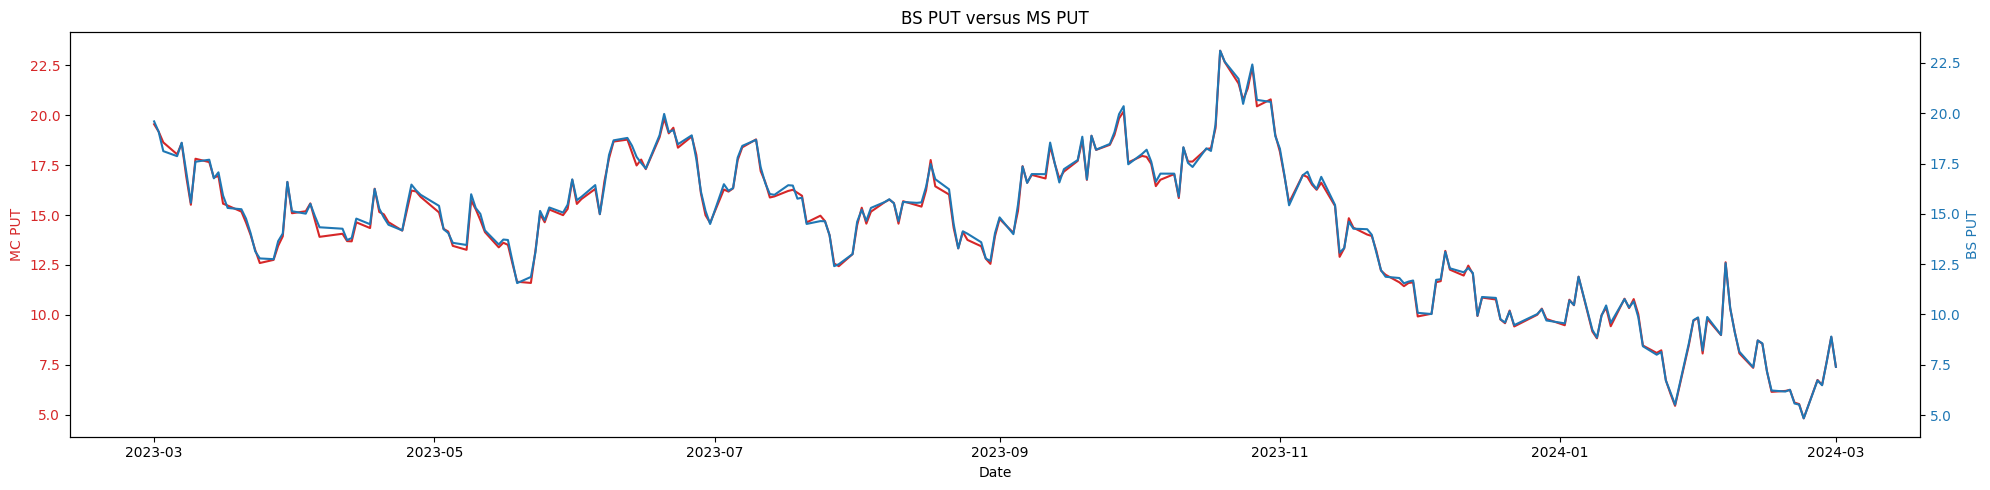

In [16]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('MC_CALL', color=color)
ax1.plot(bs_df.Date, bs_df['MC_CALL'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BS CALL', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_CALL'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('BS Call versus MS Call')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('MC PUT', color=color)
ax1.plot(bs_df.Date, bs_df['MC_PUT'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BS PUT', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_PUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('BS PUT versus MS PUT')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Check the parity condition at the

In [17]:
import numpy as np

# Constants

# Calculate the theoretical RHS of the put-call parity (considering dividends)
bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
                           110 * np.exp(- bs_df['STR'] * bs_df['T'] )
# Calculate the LHS of the put-call parity
bs_df['Calculated_LHS'] = bs_df['MC_CALL'] - bs_df['MC_PUT']

# Check if parity holds (within a small epsilon due to simulation errors)
epsilon = 0.1  # Tolerance for checking equality
bs_df['Parity_Holds'] = np.abs(bs_df['Calculated_LHS'] - bs_df['Theoretical_RHS']) < epsilon

# Display the results
print(bs_df[['MC_CALL', 'MC_PUT', 'Calculated_LHS', 'Theoretical_RHS', 'Parity_Holds']])


       MC_CALL     MC_PUT  Calculated_LHS  Theoretical_RHS  Parity_Holds
9605  2.970693  19.544867      -16.574174       -16.780956         False
9606  2.946098  19.169172      -16.223074       -16.179744          True
9607  3.339380  18.635850      -15.296469       -14.778604         False
9608  3.261018  18.039418      -14.778400       -14.555255         False
9609  2.981147  18.599883      -15.618736       -15.574173          True
...        ...        ...             ...              ...           ...
9857  0.000133   6.746001       -6.745868        -6.722279          True
9858  0.000111   6.499472       -6.499361        -6.481507          True
9859  0.000000   7.666024       -7.666024        -7.640747          True
9860  0.000000   8.900000       -8.900000        -8.900000          True
9861  0.000000   7.400000       -7.400000        -7.400000          True

[257 rows x 5 columns]


<ipython-input-17-d3f1e50bcae3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
<ipython-input-17-d3f1e50bcae3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Calculated_LHS'] = bs_df['MC_CALL'] - bs_df['MC_PUT']
<ipython-input-17-d3f1e50bcae3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [18]:
import numpy as np

# Constants

# Calculate the theoretical RHS of the put-call parity (considering dividends)
bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
                           110 * np.exp(- bs_df['STR'] * bs_df['T'] )
# Calculate the LHS of the put-call parity
bs_df['Calculated_LHS'] = bs_df['BS_CALL'] - bs_df['BS_PUT']

# Check if parity holds (within a small epsilon due to simulation errors)
epsilon = 0.1  # Tolerance for checking equality
bs_df['Parity_Holds'] = np.abs(bs_df['Calculated_LHS'] - bs_df['Theoretical_RHS']) < epsilon

# Display the results
print(bs_df[['BS_CALL', 'BS_PUT', 'Calculated_LHS', 'Theoretical_RHS', 'Parity_Holds']])


           BS_CALL     BS_PUT  Calculated_LHS  Theoretical_RHS  Parity_Holds
9605  2.811759e+00  19.592715      -16.780956       -16.780956          True
9606  2.891104e+00  19.070848      -16.179744       -16.179744          True
9607  3.335793e+00  18.114397      -14.778604       -14.778604          True
9608  3.310181e+00  17.865436      -14.555255       -14.555255          True
9609  2.959820e+00  18.533993      -15.574173       -15.574173          True
...            ...        ...             ...              ...           ...
9857  1.363417e-04   6.722415       -6.722279        -6.722279          True
9858  7.520582e-06   6.481514       -6.481507        -6.481507          True
9859  6.087509e-13   7.640747       -7.640747        -7.640747          True
9860  0.000000e+00   8.900000       -8.900000        -8.900000          True
9861  0.000000e+00   7.400000       -7.400000        -7.400000          True

[257 rows x 5 columns]


<ipython-input-18-8c343904f0f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
<ipython-input-18-8c343904f0f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Calculated_LHS'] = bs_df['BS_CALL'] - bs_df['BS_PUT']
<ipython-input-18-8c343904f0f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# Greeks


In [19]:
# Apply the function for calls and puts
bs_df[['Call_Price', 'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'call'), axis=1)
bs_df[['Put_Price', 'Put_Delta', 'Put_Gamma', 'Put_Theta', 'Put_Vega', 'Put_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'put'), axis=1)


<ipython-input-7-f3d6c99e6def>:81: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-7-f3d6c99e6def>:92: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
<ipython-input-7-f3d6c99e6def>:93: RuntimeWarning: invalid value encountered in scalar divide
  theta = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
<ipython-input-19-00da7316c8f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df[['Call_Price', 'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'call'), axis=1)
<ipython-input-19-00d

In [20]:
bs_df=bs_df.reset_index()

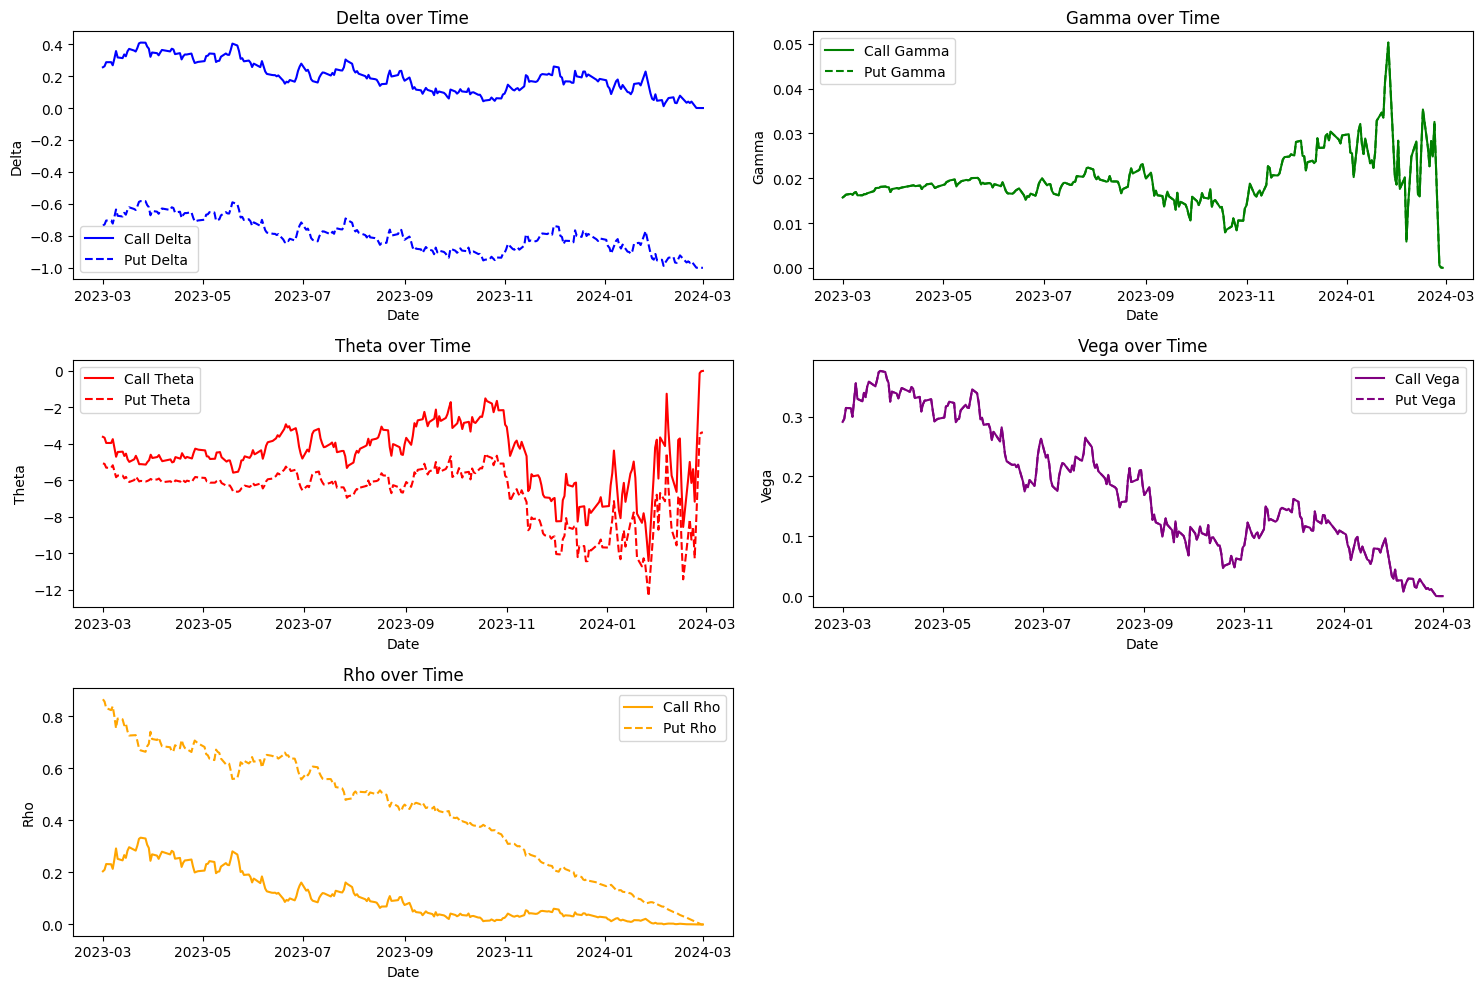

In [21]:
import matplotlib.pyplot as plt

# Setting the plot size
plt.figure(figsize=(15, 10))

greek_types = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, greek in enumerate(greek_types):
    plt.subplot(3, 2, i+1)
    plt.plot(bs_df['Date'], bs_df[f'Call_{greek}'], label=f'Call {greek}', color=colors[i])
    plt.plot(bs_df['Date'], bs_df[f'Put_{greek}'], label=f'Put {greek}', color=colors[i], linestyle='dashed')
    plt.title(f'{greek} over Time')
    plt.xlabel('Date')
    plt.ylabel(greek)
    plt.legend()

plt.tight_layout()
plt.show()


Greek shocks

In [22]:
bs_df_co = bs_df.copy()
# Apply the functions
bs_df_co[['Original_Delta', 'Original_Gamma', 'Original_Theta', 'Original_Vega', 'Original_Rho']] = bs_df_co.apply(calculate_original_greeks, axis=1, result_type='expand')
bs_df_co[['Adjusted_Delta', 'Adjusted_Gamma', 'Adjusted_Theta', 'Adjusted_Vega', 'Adjusted_Rho']] = bs_df_co.apply(calculate_adjusted_greeks, axis=1, result_type='expand')


<ipython-input-7-f3d6c99e6def>:132: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-7-f3d6c99e6def>:136: RuntimeWarning: invalid value encountered in scalar divide
  'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
<ipython-input-7-f3d6c99e6def>:137: RuntimeWarning: invalid value encountered in scalar divide
  'Theta': -S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2) + q * S * np.exp(-q * T) * norm.cdf(d1),
<ipython-input-7-f3d6c99e6def>:132: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-7-f3d6c99e6def>:136: RuntimeWarning: invalid value encountered in scalar divide
  'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
<ipython-input-7-f3d6c99e6def>:137: RuntimeWarning: invalid value encountered

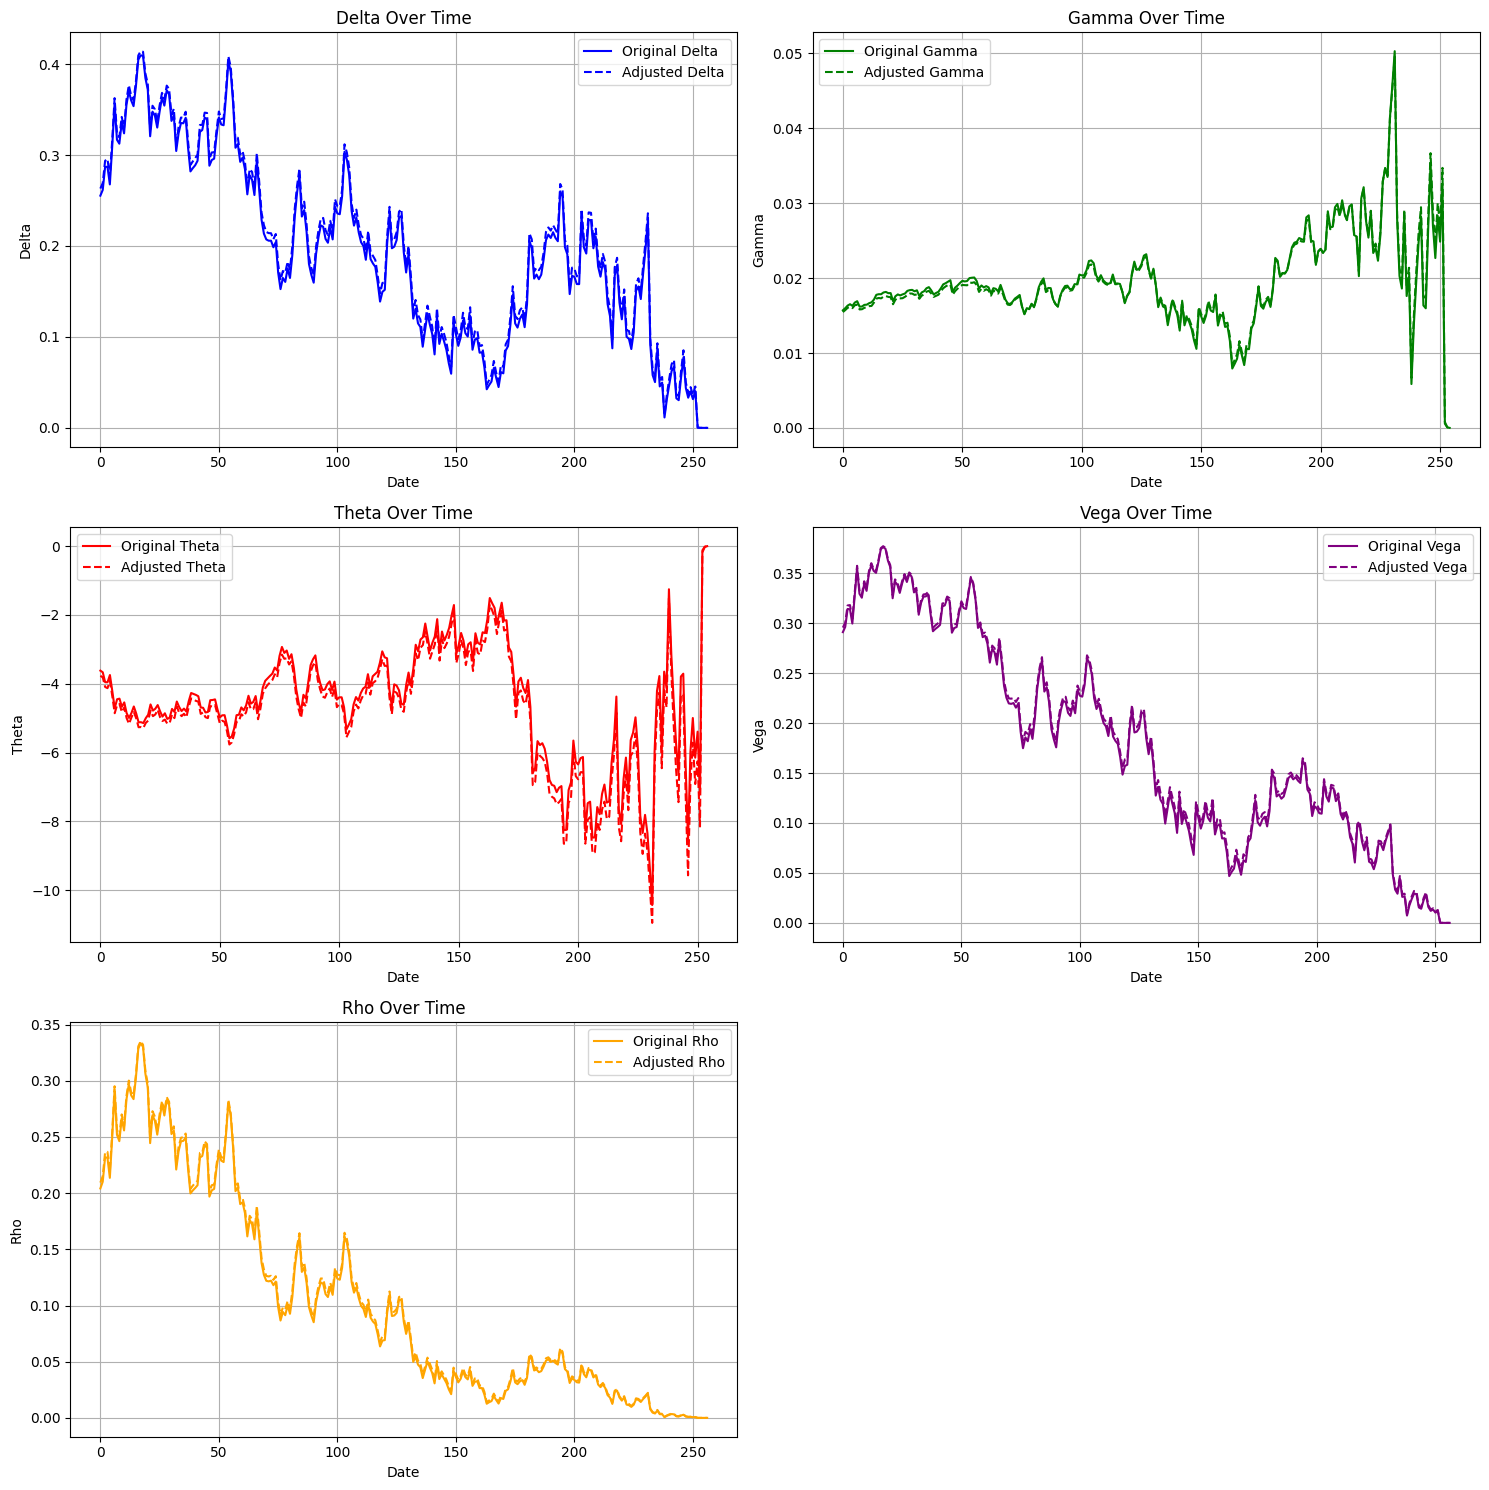

In [23]:
import matplotlib.pyplot as plt

# Ensure 'Date' is the datetime index for easier plotting

plt.figure(figsize=(15, 15))
greek_types = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, greek in enumerate(greek_types):
    plt.subplot(3, 2, i + 1)
    plt.plot(bs_df_co.index, bs_df_co[f'Original_{greek}'], label=f'Original {greek}', color=colors[i], linestyle='-')
    plt.plot(bs_df_co.index, bs_df_co[f'Adjusted_{greek}'], label=f'Adjusted {greek}', color=colors[i], linestyle='--')
    plt.title(f'{greek} Over Time')
    plt.xlabel('Date')
    plt.ylabel(greek)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Hedging

Assuming you are long 25 000 shares of your chosen asset, for the call option in 3 b), determine the number of options necessary to create a
delta-neutral portfolio (use a Covered Call or a Protective Put strategy). Interpret the result.

In [24]:

shares_long = 25000

# Calculate the number of call options to sell to achieve delta neutrality
bs_df_co['Options_to_Sell'] = shares_long / bs_df_co['Original_Delta']

In [25]:
bs_df_co = bs_df_co.reset_index()
#bs_df_co= bs_df_co[bs_df_co.index<='2024-02-28']

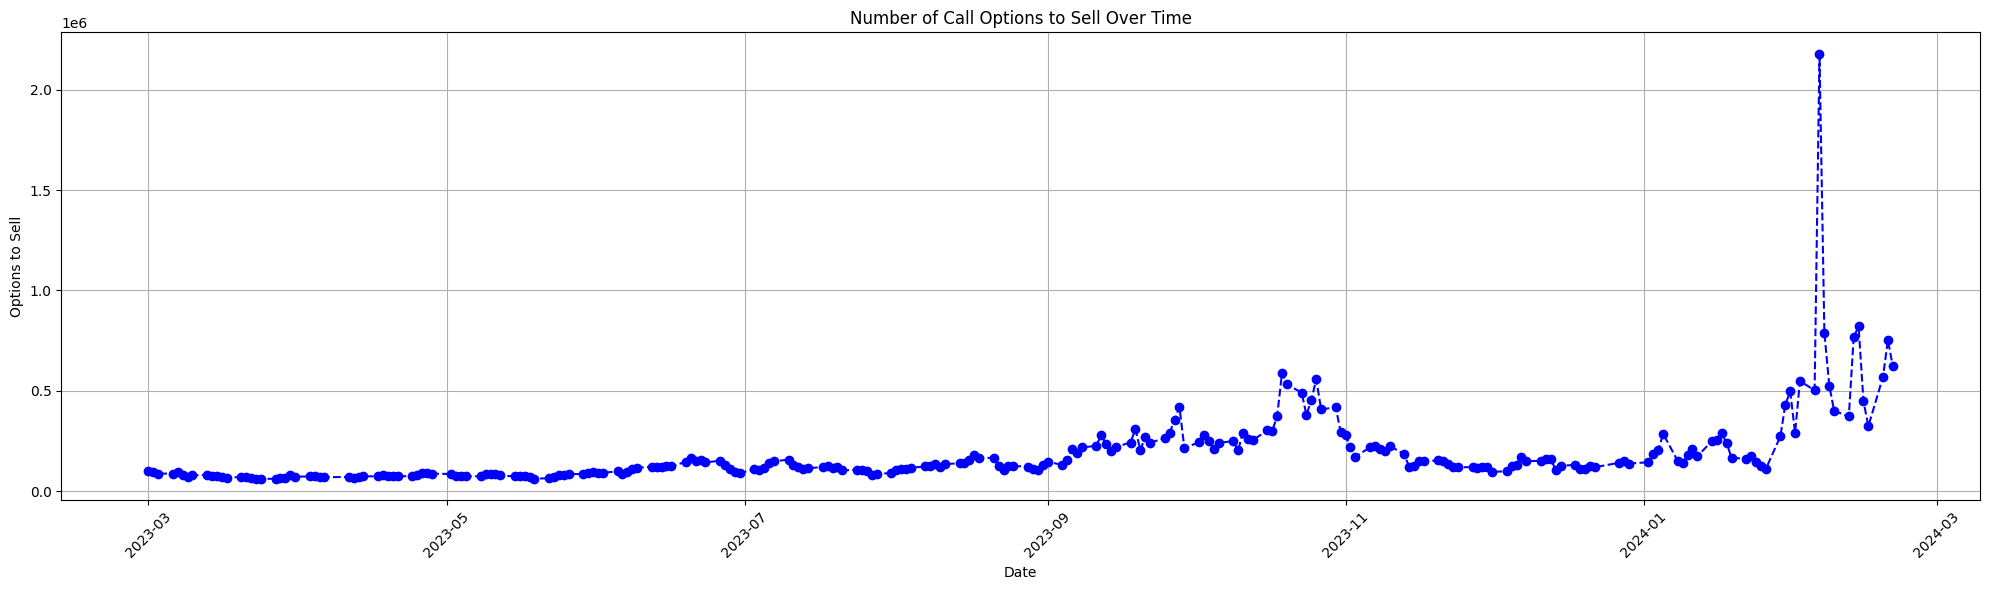

In [26]:

# Creating the plot
plt.figure(figsize=(20, 6))  # Set the figure size
plt.plot(bs_df_co.Date[:250], bs_df_co['Options_to_Sell'].iloc[:250], marker='o', linestyle='--', color='b')
plt.title('Number of Call Options to Sell Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Options to Sell')  # Y-axis label
plt.grid(True)  # Add gridlines
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give some padding
plt.show()

In [27]:
np.random.seed(0)  # For reproducibility
jump_size_mean = 1.4  # Mean jump size
jump_size_std = 0.3  # Standard deviation of the jump size
bs_df_co['Price_Jump'] = np.random.normal(jump_size_mean, jump_size_std, bs_df_co.shape[0])

# Calculate new price after the jump
bs_df_co['New_Price'] = bs_df_co['Price'] + bs_df_co['Price_Jump']

# Calculate new delta per option assuming gamma remains constant
bs_df_co['New_Delta'] = bs_df_co['Original_Delta'] + bs_df_co['Original_Gamma'] * bs_df_co['Price_Jump']

In [28]:
# Calculate the original and new number of options sold to maintain delta neutrality
bs_df_co['Options_Sold_Originally'] = shares_long / bs_df_co['Original_Delta']
bs_df_co['Options_Sold_New'] = shares_long / bs_df_co['New_Delta']

# Calculate the additional options needed to sell to maintain delta neutrality
bs_df_co['Additional_Options_to_Sell'] = bs_df_co['Options_Sold_New'] - bs_df_co['Options_Sold_Originally']


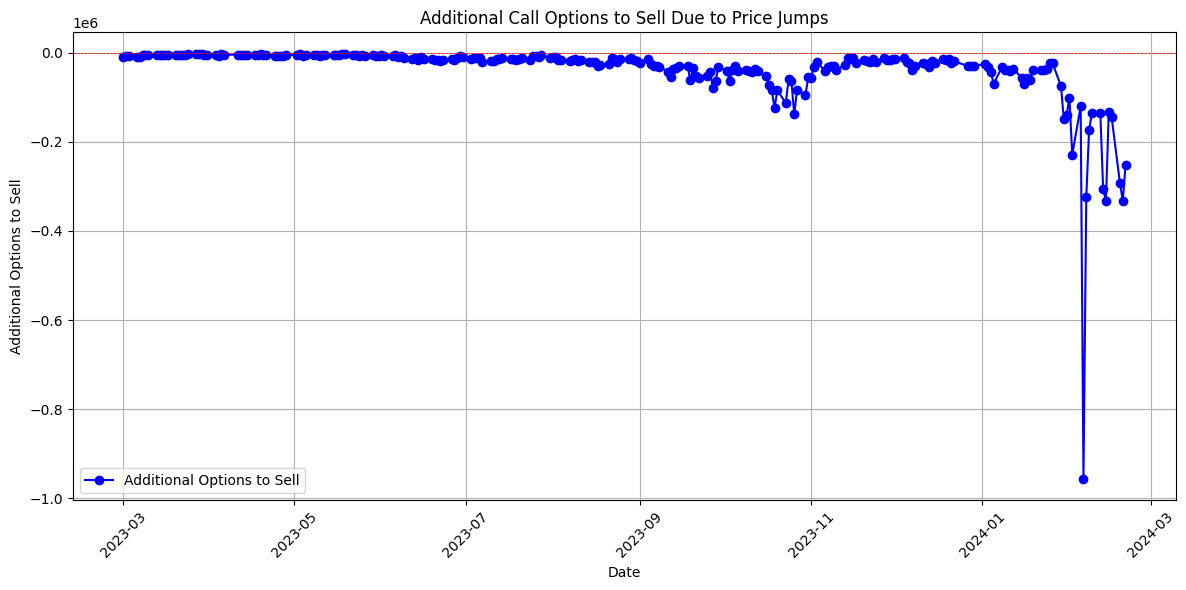

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(bs_df_co['Date'].iloc[:250], bs_df_co['Additional_Options_to_Sell'].iloc[:250], marker='o', linestyle='-', color='b', label='Additional Options to Sell')
plt.title('Additional Call Options to Sell Due to Price Jumps')
plt.xlabel('Date')
plt.ylabel('Additional Options to Sell')
plt.axhline(0, color='red', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give some padding
plt.show()


In [ ]:
bs_df_co.columns

Index(['level_0', 'index', 'Date', 'Price', 'STR', 'Daily Returns',
       'Rolling_Volatility3M', 'Rolling_Volatility2M', 'Rolling_Volatility1M',
       'q', 'DTE', 'T', 'BS_CALL', 'BS_PUT', 'MC_CALL', 'MC_PUT',
       'Theoretical_RHS', 'Calculated_LHS', 'Parity_Holds', 'Call_Price',
       'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho',
       'Put_Price', 'Put_Delta', 'Put_Gamma', 'Put_Theta', 'Put_Vega',
       'Put_Rho', 'Original_Delta', 'Original_Gamma', 'Original_Theta',
       'Original_Vega', 'Original_Rho', 'Adjusted_Delta', 'Adjusted_Gamma',
       'Adjusted_Theta', 'Adjusted_Vega', 'Adjusted_Rho', 'Options_to_Sell',
       'Price_Jump', 'New_Price', 'New_Delta', 'Options_Sold_Originally',
       'Options_Sold_New', 'Additional_Options_to_Sell'],
      dtype='object')

In [30]:
shares_long = 25000  # Total shares you are long
hedging_option_gamma = -0.01  # Gamma of hedging options (negative for put options)

# Calculate total gamma exposure from the existing call options
bs_df_co['Total_Gamma_Existing_Options'] = bs_df_co['Original_Gamma'] * (shares_long / bs_df_co['Original_Delta'])

# Calculate the number of hedging options required to offset this gamma
bs_df_co['Hedging_Options_Required'] = -bs_df_co['Total_Gamma_Existing_Options'] / hedging_option_gamma

# Display the DataFrame with new columns
print(bs_df_co[['Date', 'Price', 'Original_Delta', 'Original_Gamma', 'Total_Gamma_Existing_Options', 'Hedging_Options_Required']])

          Date   Price  Original_Delta  Original_Gamma  \
0   2023-03-01   91.00    2.552924e-01    1.569980e-02   
1   2023-03-02   91.60    2.616357e-01    1.598419e-02   
2   2023-03-03   93.00    2.868045e-01    1.633264e-02   
3   2023-03-06   93.22    2.871365e-01    1.651613e-02   
4   2023-03-07   92.20    2.676699e-01    1.629529e-02   
..         ...     ...             ...             ...   
252 2024-02-26  103.25    2.853342e-04    5.598936e-04   
253 2024-02-27  103.50    2.214016e-05    6.203677e-05   
254 2024-02-28  102.35    4.026998e-12    2.609403e-11   
255 2024-02-29  101.10    0.000000e+00             NaN   
256 2024-03-01  102.60    0.000000e+00             NaN   

     Total_Gamma_Existing_Options  Hedging_Options_Required  
0                     1537.433376              1.537433e+05  
1                     1527.332221              1.527332e+05  
2                     1423.673460              1.423673e+05  
3                     1438.003231              1.438003

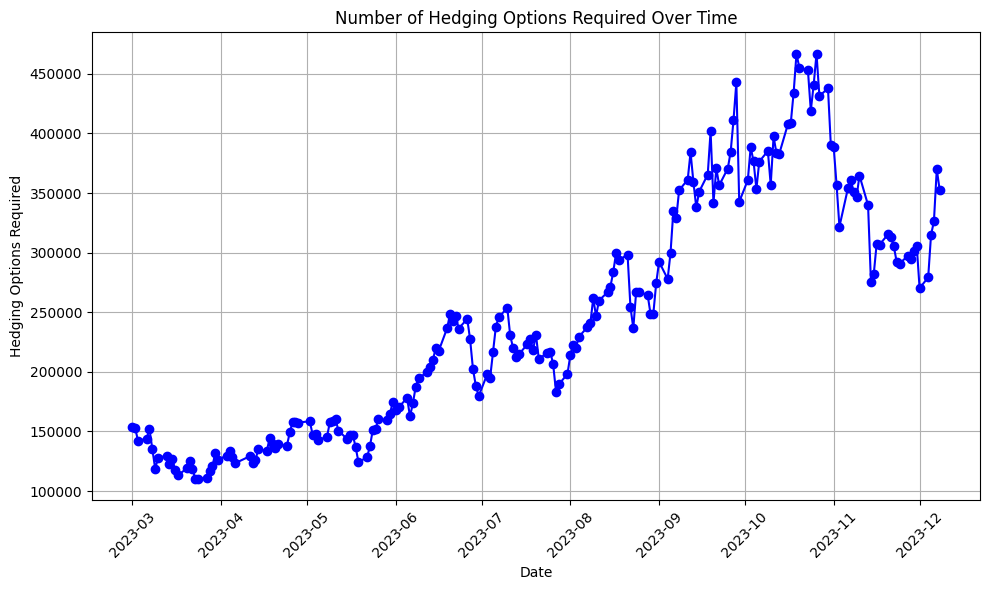

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bs_df_co['Date'][:200], bs_df_co['Hedging_Options_Required'][:200], marker='o', linestyle='-', color='b')
plt.title('Number of Hedging Options Required Over Time')
plt.xlabel('Date')
plt.ylabel('Hedging Options Required')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ZeroDivisionError: float division by zero

In [32]:
bs_df_co.columns

Index(['level_0', 'index', 'Date', 'Price', 'STR', 'Daily Returns',
       'Rolling_Volatility3M', 'Rolling_Volatility2M', 'Rolling_Volatility1M',
       'q', 'DTE', 'T', 'BS_CALL', 'BS_PUT', 'MC_CALL', 'MC_PUT',
       'Theoretical_RHS', 'Calculated_LHS', 'Parity_Holds', 'Call_Price',
       'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho',
       'Put_Price', 'Put_Delta', 'Put_Gamma', 'Put_Theta', 'Put_Vega',
       'Put_Rho', 'Original_Delta', 'Original_Gamma', 'Original_Theta',
       'Original_Vega', 'Original_Rho', 'Adjusted_Delta', 'Adjusted_Gamma',
       'Adjusted_Theta', 'Adjusted_Vega', 'Adjusted_Rho', 'Options_to_Sell',
       'Price_Jump', 'New_Price', 'New_Delta', 'Options_Sold_Originally',
       'Options_Sold_New', 'Additional_Options_to_Sell',
       'Total_Gamma_Existing_Options', 'Hedging_Options_Required'],
      dtype='object')